In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

#!pip install torchsummary
#from torchsummary import summary

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import RandomSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
    transforms.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
client_0_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_0', transform = transform)
client_1_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_1', transform = transform)
client_2_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_2', transform = transform)
client_3_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_3', transform = transform)
client_4_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_4', transform = transform)
client_5_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_5', transform = transform)
client_6_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_6', transform = transform)
client_7_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_7', transform = transform)
client_8_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_8', transform = transform)
client_9_data = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train/Client_9', transform = transform)

In [5]:
global_test = ImageFolder(root = '/kaggle/input/dataset-v2-1/Dataset v2.1/Test', transform = test_transform)

In [6]:
root_dir = '/kaggle/input/dataset-v2-1/Dataset v2.1/Train'

# Iterate through clients
for client in range(10):
    client_dir = os.path.join(root_dir, f'Client_{client}')

    # Get a list of subdirectories (folders) within the client directory
    subdirectories = [d for d in os.listdir(client_dir) if os.path.isdir(os.path.join(client_dir, d))]

    # Print the number of images in each class for the current client
    print(f"\nClient {client} Data Distribution:")
    for folder in subdirectories:
        folder_path = os.path.join(client_dir, folder)
        image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        class_count = len(image_files)
        print(f"{folder}: {class_count}")


Client 0 Data Distribution:
pituitary: 158
no-tumor: 167
meningioma: 61
glioma: 58

Client 1 Data Distribution:
pituitary: 233
no-tumor: 89
meningioma: 270
glioma: 110

Client 2 Data Distribution:
pituitary: 283
no-tumor: 171
meningioma: 216
glioma: 207

Client 3 Data Distribution:
pituitary: 71
no-tumor: 145
meningioma: 121
glioma: 80

Client 4 Data Distribution:
pituitary: 76
no-tumor: 327
meningioma: 146
glioma: 146

Client 5 Data Distribution:
pituitary: 133
no-tumor: 147
meningioma: 64
glioma: 143

Client 6 Data Distribution:
pituitary: 143
no-tumor: 66
meningioma: 58
glioma: 257

Client 7 Data Distribution:
pituitary: 65
no-tumor: 242
meningioma: 144
glioma: 133

Client 8 Data Distribution:
pituitary: 141
no-tumor: 160
meningioma: 135
glioma: 58

Client 9 Data Distribution:
pituitary: 154
no-tumor: 81
meningioma: 124
glioma: 129


In [7]:
classes = 4
input_dim = 65536

rounds = 50
batch_size = 32
epochs_per_client = 5
learning_rate = 1e-2

In [8]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

if torch.cuda.is_available():
    # Get the GPU device name
    device_name = torch.cuda.get_device_name(0)  # 0 is the default GPU index
    print(f'GPU Device Name: {device_name}')
else:
    print('No GPU available.')

GPU Device Name: Tesla P100-PCIE-16GB


In [9]:
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 20, 3)
        self.conv2 = torch.nn.Conv2d(20, 128, 3)
        self.conv3 = torch.nn.Conv2d(128, 256, 3, stride=2)
        self.conv4 = torch.nn.Conv2d(256, 512, 3, stride=2)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(4608, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 128)
        self.fc4 = torch.nn.Linear(128, 4)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1,
                             'conv2': self.conv2,
                             'conv3': self.conv3,
                             'conv4': self.conv4,
                             'fc1': self.fc1,
                             'fc2': self.fc2,
                             'fc3': self.fc3,
                             'fc4': self.fc4,
                             }

    def forward(self, x_batch):

        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.conv4(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=32, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [10]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        test_loss, test_acc = net.evaluate(global_test)
        print('{}: Train Loss = {}, Train Accuracy = {}, Test Loss = {}, Test Accuracy = {}'.format(self.client_id, 
                                                                    round(train_history[-1][0], 4), round(train_history[-1][1], 4),
                                                                    round(test_loss, 4), round(test_acc, 4)))
        
        self.acc = round(train_history[-1][1], 4)
        self.loss = round(train_history[-1][0], 4)
        
        self.test_acc = test_acc
        self.test_loss = test_loss
        
        return net.get_parameters()
    
    def get_accuracy(self):
        return self.acc
    
    def get_loss(self):
        return self.loss
    
    def get_test_accuracy(self):
        return self.acc
    
    def get_test_loss(self):
        return self.loss

In [11]:
client_datasets = [client_0_data, client_1_data, client_2_data, client_3_data, client_4_data, client_5_data, client_6_data, client_7_data, client_8_data, client_9_data]

In [12]:
num_clients = len(client_datasets)
num_clients

10

In [13]:
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(len(client_datasets))]

In [14]:
clients[0].get_dataset_size()

444

In [15]:
total_dataset_size = len(client_0_data) + len(client_1_data) + len(client_2_data) + len(client_3_data) + len(client_4_data) + len(client_5_data) + len(client_6_data) + len(client_7_data) + len(client_8_data) + len(client_9_data)
total_dataset_size

5712

In [16]:
for client in clients:
    weightage  = client.get_dataset_size() / total_dataset_size
    print(weightage)

0.07773109243697479
0.12289915966386554
0.15353641456582634
0.07300420168067227
0.12167366946778711
0.08525910364145659
0.09173669467787114
0.10224089635854341
0.08648459383753501
0.08543417366946779


In [17]:
for client in clients:
    print(client.get_client_id() ,client.get_dataset_size() / total_dataset_size)

client_0 0.07773109243697479
client_1 0.12289915966386554
client_2 0.15353641456582634
client_3 0.07300420168067227
client_4 0.12167366946778711
client_5 0.08525910364145659
client_6 0.09173669467787114
client_7 0.10224089635854341
client_8 0.08648459383753501
client_9 0.08543417366946779


In [18]:
global_net = to_device(FederatedNet(), device)
history = []

In [19]:
client_metrics_acc_train = [[0] * num_clients for _ in range(rounds)]
client_metrics_loss_train = [[0] * num_clients for _ in range(rounds)]
client_metrics_acc_test = [[0] * num_clients for _ in range(rounds)]
client_metrics_loss_test = [[0] * num_clients for _ in range(rounds)]

client_index_map = {client: i for i, client in enumerate(clients)}

In [20]:
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    
    for client in clients:
        client_parameters = client.train(curr_parameters)
        
        client_index = client_index_map[client]
        
        client_metrics_acc_train[i][client_index] = client.get_accuracy()
        client_metrics_loss_train[i][client_index] = client.get_loss()
        
        client_metrics_acc_test[i][client_index] = client.get_test_accuracy()
        client_metrics_loss_test[i][client_index] = client.get_test_loss()
        #weightage  = client.get_dataset_size() / total_dataset_size
        for layer_name in client_parameters:
            if i<10:
                if client.get_client_id() == 'client_1' or client.get_client_id() == 'client_2' or client.get_client_id() == 'client_4' :
                    weightage  = clients[2].get_dataset_size() / total_dataset_size
                
                    new_parameters[layer_name]['weight'] += weightage * client_parameters[layer_name]['weight']
                    new_parameters[layer_name]['bias'] += weightage * client_parameters[layer_name]['bias']
            
                else:
                    weightage  = client.get_dataset_size() / total_dataset_size
                
                    new_parameters[layer_name]['weight'] += weightage * client_parameters[layer_name]['weight']
                    new_parameters[layer_name]['bias'] += weightage * client_parameters[layer_name]['bias']
                    
            else:
                weightage  = client.get_dataset_size() / total_dataset_size
                
                new_parameters[layer_name]['weight'] += weightage * client_parameters[layer_name]['weight']
                new_parameters[layer_name]['bias'] += weightage * client_parameters[layer_name]['bias']                
    
    
    
    
    
    global_net.apply_parameters(new_parameters)

    dev_loss, dev_acc = global_net.evaluate(global_test)
    print('After round {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1,
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((dev_loss, dev_acc))

Start Round 1 ...
client_0: Train Loss = 1.3421, Train Accuracy = 0.4538, Test Loss = 1.3774, Test Accuracy = 0.2955
client_1: Train Loss = 1.3207, Train Accuracy = 0.3844, Test Loss = 1.4203, Test Accuracy = 0.2173
client_2: Train Loss = 1.3745, Train Accuracy = 0.3224, Test Loss = 1.392, Test Accuracy = 0.282
client_3: Train Loss = 1.3713, Train Accuracy = 0.3237, Test Loss = 1.393, Test Accuracy = 0.2876
client_4: Train Loss = 1.2865, Train Accuracy = 0.4712, Test Loss = 1.4262, Test Accuracy = 0.2876
client_5: Train Loss = 1.3706, Train Accuracy = 0.2863, Test Loss = 1.3891, Test Accuracy = 0.2131
client_6: Train Loss = 1.2643, Train Accuracy = 0.4847, Test Loss = 1.4508, Test Accuracy = 0.2131
client_7: Train Loss = 1.3328, Train Accuracy = 0.4128, Test Loss = 1.4059, Test Accuracy = 0.2876
client_8: Train Loss = 1.3712, Train Accuracy = 0.3175, Test Loss = 1.3814, Test Accuracy = 0.2876
client_9: Train Loss = 1.3728, Train Accuracy = 0.2695, Test Loss = 1.3972, Test Accuracy = 0.

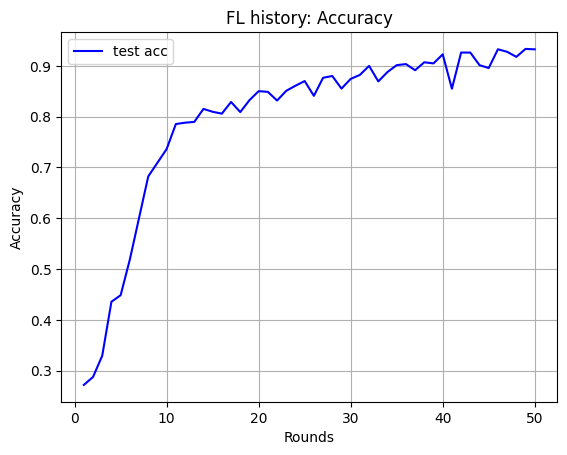

In [21]:
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='test acc')
plt.legend()
plt.title('FL history: Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

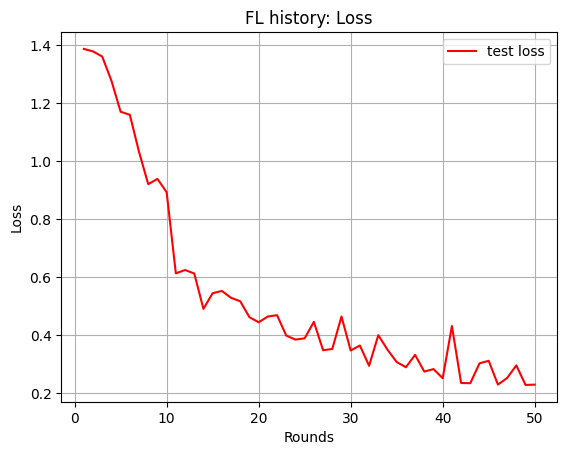

In [22]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='test loss')
plt.legend()
plt.title('FL history: Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

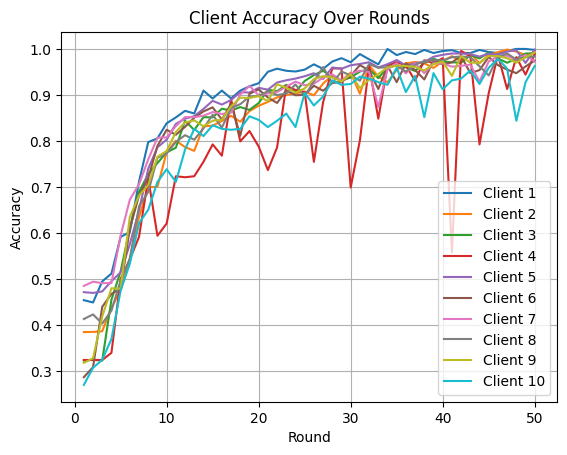

In [23]:
rounds = len(client_metrics_acc_train)
num_clients = len(client_metrics_acc_train[0])

# Plot the accuracy for all clients across rounds
for j in range(num_clients):
    client_accuracies = [client_metrics_acc_train[i][j] for i in range(rounds)]
    plt.plot(range(1, rounds + 1), client_accuracies, label=f'Client {j + 1}')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Client Accuracy Over Rounds')
plt.legend()
plt.grid(True)
plt.show()

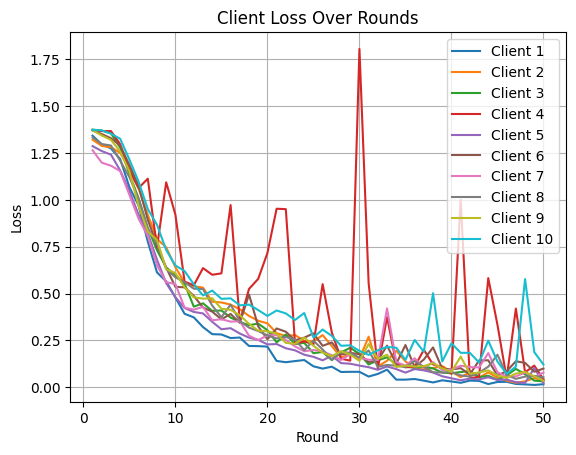

In [24]:
rounds = len(client_metrics_loss_train)
num_clients = len(client_metrics_loss_train[0])

# Plot the accuracy for all clients across rounds
for j in range(num_clients):
    client_accuracies = [client_metrics_loss_train[i][j] for i in range(rounds)]
    plt.plot(range(1, rounds + 1), client_accuracies, label=f'Client {j + 1}')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Client Loss Over Rounds')
plt.legend()
plt.grid(True)
plt.show()

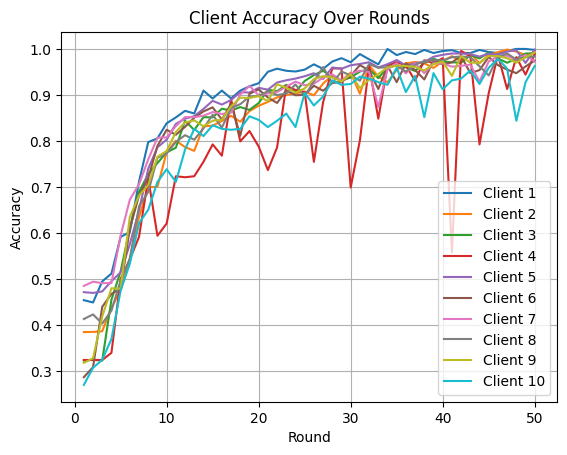

In [25]:
rounds = len(client_metrics_acc_test)
num_clients = len(client_metrics_acc_test[0])

# Plot the accuracy for all clients across rounds
for j in range(num_clients):
    client_accuracies = [client_metrics_acc_test[i][j] for i in range(rounds)]
    plt.plot(range(1, rounds + 1), client_accuracies, label=f'Client {j + 1}')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Client Accuracy Over Rounds')
plt.legend()
plt.grid(True)
plt.show()

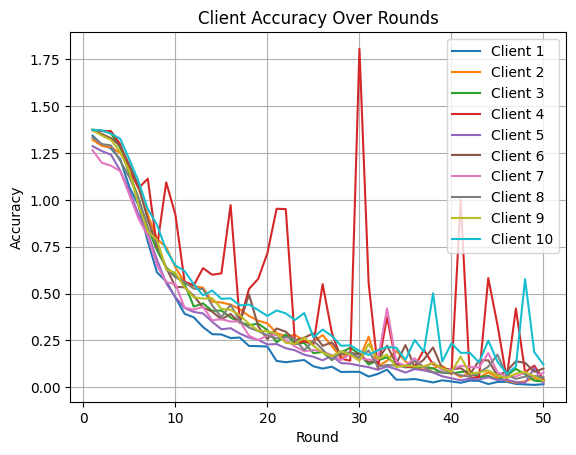

In [26]:
rounds = len(client_metrics_loss_test)
num_clients = len(client_metrics_loss_test[0])

# Plot the accuracy for all clients across rounds
for j in range(num_clients):
    client_accuracies = [client_metrics_loss_test[i][j] for i in range(rounds)]
    plt.plot(range(1, rounds + 1), client_accuracies, label=f'Client {j + 1}')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Client Accuracy Over Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
model_scripted = torch.jit.script(global_net) # Export to TorchScript
model_scripted.save('/kaggle/working/model_manual_agg_dist_data.pth')